# PCG Heightmap Analysis

This notebook will run an analyis of heightmaps generated procedurally for our Master Thesis. 
The greyscale heightmaps will be imported, and thresholded into N segments based on a KMeans analysis of the image.
Each segment will have it's fractal dimension (Minkowski–Bouligand dimension) measured using the Box Counting method
The N dimensions for each image will then be plotted in 2 dimensions for visual analysis using PCA

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.cluster import KMeans
import os
from os import listdir

In [2]:
path = "img"
suffix = ".png"
print(f'Looking for files ending in: {suffix} in directory : {path}\n')

files = []
for file in os.listdir(path):
    if file.endswith(suffix):
        files.append(file)

print(f'Found {len(files)} files ending with {suffix}.')

Looking for files ending in: .png in directory : img

Found 5 files ending with .png.


## Display sample heightmap image

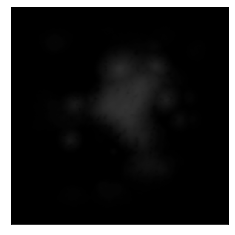

In [4]:
img = cv2.imread(path + '\\' + files[0])
plt.imshow(img)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

## KMeans clustering of heightmaps

```One of the most commonly used clustering algorithms is k-means. Here, the k represents the number of clusters (not to be confused with k-nearest neighbor). Let’s understand how k-means works:

First, randomly select k initial clusters

Randomly assign each data point to any one of the k clusters

Calculate the centers of these clusters

Calculate the distance of all the points from the center of each cluster

Depending on this distance, the points are reassigned to the nearest cluster

Calculate the center of the newly formed clusters

Finally, repeat steps (4), (5) and (6) until either the center of the clusters does not change or we reach the set number of iterations

The key advantage of using k-means algorithm is that it is simple and easy to understand. We are assigning the points to the clusters which are closest to them.```

from https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/

### Prepare data for processing
- Read the files from disc as images.
- Store the images in an array
- Reshape the images from 3D arrays of (x, y, channels) to 2D arrays of (x*y, channels)

In [5]:
image_data = []

for f in files:
    original = cv2.imread(path + '\\' + f, 0)
    reshaped = original.reshape(img.shape[0]*img.shape[1], 1)
    image_data.append([original, reshaped])
    
print('original shape: ' + str(image_data[0][0].shape))
print('new shape: ' + str(image_data[0][1].shape))

original shape: (513, 513)
new shape: (263169, 1)


# Perform KMeans clustering

Use the KMeans clustering algorithm to determine height bands in the heightmaps
- Return an array of the cluster centers (i.e. the values of the different height bands) sorted from lowest to highest
- Also return a segmented image to visualise these values

In [21]:
def get_kmeans_clusters(image_data, k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(image_data[1])     # perform KMeans clustering on reshaped image
    mean_values = kmeans.cluster_centers_.T[0]                           # return the values of the cluster centers
    mean_values = np.sort(mean_values, axis=None)                        # sort the means from low to hight
    pic2show = kmeans.cluster_centers_[kmeans.labels_]                   # generate a segmented image
    
    # reshape the segmented image to a 2D array
    # divide by 255 to remap from uint8 (0-255) to float64 (0-1)
    cluster_pic = (pic2show.reshape(image_data[0].shape[0], image_data[0].shape[1]))/255 

    return mean_values, cluster_pic                                      # return the cluster centers (means) and the segmented image

In [22]:
image_cluster_data = []
for data in image_data:
    image_cluster_data.append(get_kmeans_clusters(data, 10))

#### Display Segmented Images

These images are the result of sementing the heightmap using KMeans. They should be somewhat remeniscent of topological maps.

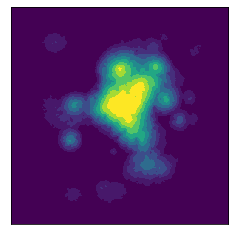

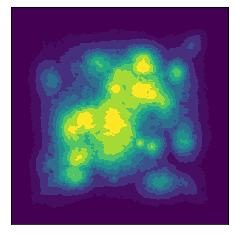

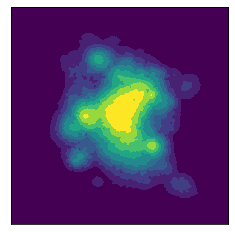

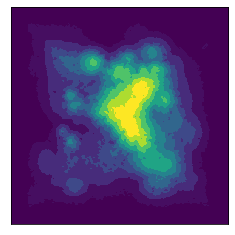

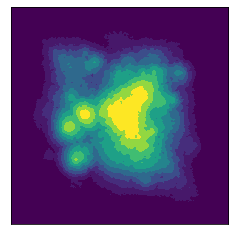

In [23]:
for data in image_cluster_data:
    plt.figure()
    plt.imshow(data[1]) # image_cluster_data[0] is the cluster centers, image_cluster_data[1] is the segmented image
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

In [9]:
# Each image should have an array of binary images
binary_images = []
def split_image_clusters(img, mean_values):
    binary_images = []
    for i in range (0, len(mean_values)):
        ret,thresh = cv2.threshold(img,mean_values[i],255,cv2.THRESH_BINARY)
        #img_c = cv2.Canny(thresh, mean_values[i] - 0.01, mean_values[i] + 0.01)
        float_thresh = thresh/255
        binary_images.append(float_thresh)
    return binary_images

for i in range(len(image_data)):
    binary_images.append(split_image_clusters(image_data[i][0], image_cluster_data[i][0]))


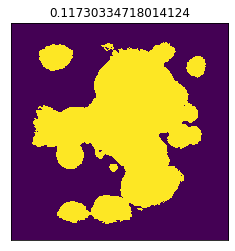

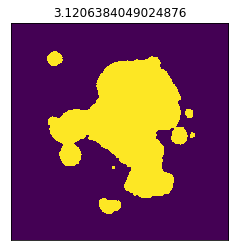

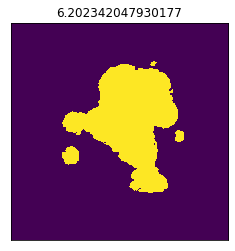

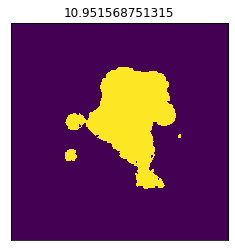

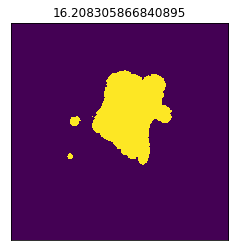

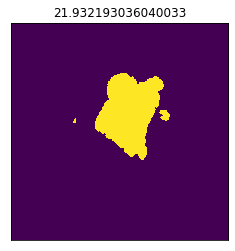

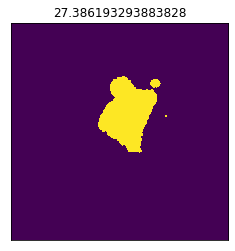

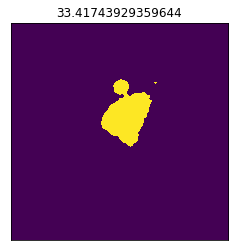

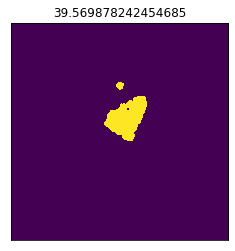

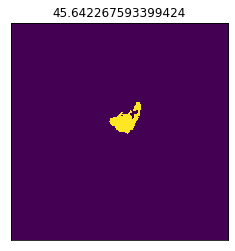

In [10]:

for i in range(0, len(binary_images[0])):
    plt.imshow(binary_images[0][i])#.astype(np.uint8)) # Otherwise it caps at 1
    plt.title(str(image_cluster_data[0][0][i])) #[source][data_type][binary_image]
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

In [11]:
print(binary_images[0][0].shape)

(513, 513)


In [12]:
def box_count(Z, k):
    ''''''
    S = np.add.reduceat(
        np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                           np.arange(0, Z.shape[1], k), axis=1)
    return len(np.where((S > 0) & (S < k*k))[0])


In [13]:
test = np.array([
    [0, 0, 255, 0, 255, 255],
    [0, 1, 1, 0, 1, 1],
    [0, 1, 1, 0, 1, 0],
    [0, 1, 1, 1, 1, 0],
    [0, 0, 1, 1, 1, 0],
    [0, 0, 0, 0, 1, 0],
])
print(box_count(test, 2))
print(box_count(test, 3))
print (box_count(binary_images[0][0], 2))
#print(((binary_images[0])/255)[257][256])


6
2
1010


In [14]:
scale_factors = [2, 4, 8, 16, 32]
N = []

for s in scale_factors:
    N.append(box_count(binary_images[0][0], s*2))

print(N)

[733, 407, 202, 91, 44]


<function matplotlib.pyplot.show(*args, **kw)>

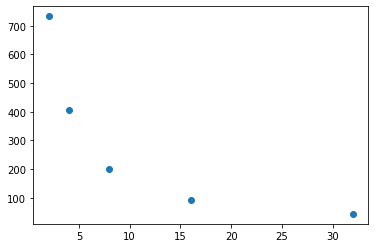

In [15]:
plt.scatter(scale_factors, N)
plt.show

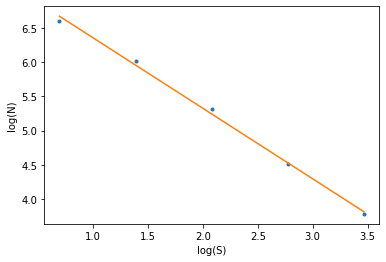

In [16]:
from numpy.polynomial.polynomial import polyfit

constant, slope = polyfit(np.log(scale_factors), np.log(N), 1)

def plot_data_with_polynomial(N, constant, slope, axis):
    axis.plot(np.log(scale_factors), np.log(N), '.')
    axis.plot(np.log(scale_factors), constant + slope * np.log(scale_factors), '-')
    axis.ylabel('log(N)')
    axis.xlabel('log(S)')

plot_data_with_polynomial(N, constant, slope, plt)

In [17]:
def fractal_dimension(img, scale_factors):
    '''Using the box counting method, FD is the slope of the best fit line on the plot of the log log plot of the number of boxes and the size of boxes'''
    N = []
    for s in scale_factors:
        N.append(box_count(img, s*2))
        
    constant, slope = polyfit(np.log(scale_factors), np.log(N), 1)
    
    return [N, constant, slope]


In [28]:
plot_data = []
data = []
for i in range (len(binary_images)):
    FD = []
    for img in binary_images[i]:
        N, constant, slope = fractal_dimension(img, scale_factors)
        FD.append(slope)
        plot_data.append([N, constant, slope])
    data.append(FD)

print(data)

[[-1.0277565883060584, -1.0237910201575149, -0.977259827324892, -0.9860170824270444, -0.9547956623829069, -0.9952433070529728, -1.057768193093124, -0.9931568569324174, -0.9555215157327107, -0.9891527201299085], [-0.9803156551951876, -0.9536098949135887, -1.0904127644280397, -1.083456007088921, -1.0171080067171558, -0.9496053084858963, -0.9750260665358182, -1.068146760835356, -1.1593365154491946, -0.9920648733885111], [-0.9593152362346764, -1.0304359388761308, -1.0498909631018287, -0.9946605162568897, -1.0186001152928887, -0.94753067874498, -0.9571603587605234, -0.948757123710809, -1.0522409989305044, -1.1176952268336287], [-0.9803156551951876, -0.9994821283480712, -1.1321928094887364, -1.0869178503378523, -1.058555027837017, -1.0105970157478668, -1.0502434277469759, -0.95546660105996, -1.0285488916680303, -1.0443948158174072], [-0.9758850819787288, -0.9841084452330932, -1.0168130763796779, -0.9744214261903857, -1.0221500993393482, -0.9779932931413671, -1.0838939855088603, -1.0188323912

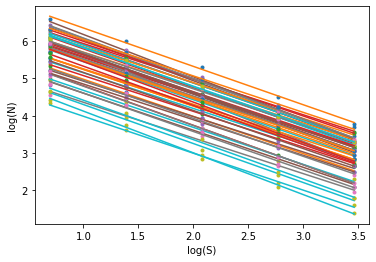

In [27]:
for pd in plot_data:
    plot_data_with_polynomial(pd[0], pd[1], pd[2], plt)

## Principal Component Analysis

In [39]:
from sklearn import decomposition


In [40]:
pca = decomposition.PCA(n_components = 2)
pca.fit(data)
out = pca.transform(data)
print(out.shape)

(5, 2)


<function matplotlib.pyplot.show(*args, **kw)>

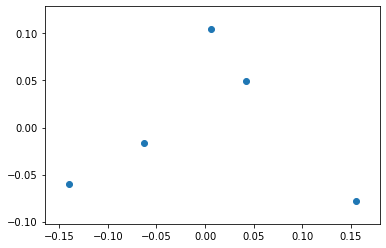

In [41]:
plt.scatter(out[:, 0], out[:, 1])
plt.show